In [264]:
import os
import numpy as np
import datetime
import pandas as pd
import matplotlib as mpl
import warnings
import matplotlib.pyplot as plt
import xarray as xr

import scipy.stats as stats

# SuppressWarnings and SuppressPlots should be in snake_case
suppress_warnings = True
suppress_plots = False

# Suppress Warnings
if suppress_warnings:
    warnings.filterwarnings("ignore")

if suppress_plots:
    import matplotlib
    matplotlib.use("Agg")

print(datetime.datetime.ctime(datetime.datetime.today()))
print("Matplotlib: ", mpl.__version__)
print("Numpy     : ", np.__version__)
print("Pandas   : ", pd.__version__)
print("Xarray   : ", xr.__version__)

Tue Oct 17 16:39:26 2023
Matplotlib:  3.1.1
Numpy     :  1.17.2
Pandas   :  0.25.1
Xarray   :  0.14.0


## OPENING OCEAN TEMP PROXY DATA FILE

In [265]:
# Setting a path to the Excel file
path = '/glade/u/home/nwrye/OceanTemps_Compiles/PlioMIP2data.xlsx'

# Load data from Excel into a pandas DataFrame
df = pd.read_excel(path)

# Remove the third row (index 2)
df = df.drop(2, axis=0)

# Selecting specific columns from the DataFrame (longitude, depth, -95%CL, median, 95%CL)
data = df.iloc[:, [1, 2, 3, 4, 5, 6]]

# Convert DataFrame to a numpy array to allow direct indexing and modification
data_array = data.to_numpy()

# Find the indices of the negative values in the first column
negative_indices = data_array[:, 0] < 0

# Add 360 to the negative values using the indices
data_array[negative_indices, 0] += 360

# Convert the modified numpy array back to a DataFrame (if needed)
data_modified = pd.DataFrame(data_array, columns=data.columns)

# Renaming columns
data_modified.columns = ['longitude', 'depth', 'species', 'neg95', 'median', 'pos95']

# Changing the depth value in the first row to 10
data_modified.at[0:1, 'depth'] = 15

# Multiplying all values in the depth column by -1
data_modified['depth'] *= -1

# Replace NaN values in the 'longitude' column with 0 (or any default value)
data_modified['longitude'].fillna(0, inplace=True)

# Round the 'longitude' values to the nearest whole number
data_modified['longitude'] = data_modified['longitude'].round()

# Convert the DataFrame to an xarray Dataset
dsa = data_modified.to_xarray()

dsa['depth'] = dsa['depth'].astype('float')

dsa['neg95'] = dsa['neg95'].astype('float')

dsa['median'] = dsa['median'].astype('float')

dsa['pos95'] = dsa['pos95'].astype('float')

dsa['species'] = dsa['species'].astype('str')

print(dsa)

<xarray.Dataset>
Dimensions:    (index: 7)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6
Data variables:
    longitude  (index) float64 265.0 159.0 159.0 278.0 159.0 249.0 278.0
    depth      (index) float64 -15.0 -15.0 -48.0 -114.0 -210.0 -210.0 -210.0
    species    (index) <U10 'alkenones' 'alkenones' ... 'tumida' 'tumida'
    neg95      (index) float64 1.338 0.8068 0.988 5.799 3.441 3.575 3.678
    median     (index) float64 2.434 1.168 0.923 6.593 3.8 4.05 4.298
    pos95      (index) float64 4.006 1.326 0.8945 7.791 4.658 4.726 5.489


## OPENING PLIOMIP2 ANNUAL MEAN OCEAN TEMP DATA FILES 

In [266]:
# Define the directory path for slice files
path = '/glade/u/home/nwrye/OceanTemps_Compiles/slicefiles/'

# List of file names to process for plio files and pi files respectively
pliofile_names = ['CCSM4_plio.nc', 'CESM1.2_plio.nc', 'CESM2_plio.nc', 'COSMOS_plio.nc',
                  'EC_Earth3.3_plio.nc', 'HADGEM3_NEW_1997_plio.nc','MIROC4_2004_plio.nc', 'Utrecht_CESM1.0.5_plio.nc','IPSLCM6A_LR_plio.nc', 'GISS_plio.nc',
                 'LEEDS_plio.nc', 'NorESM-F_plio.nc']

pifile_names = ['CCSM4_pi.nc', 'CESM1.2_pi.nc',
                'CESM2_pi.nc', 'COSMOS_pi.nc', 'EC_Earth3.3_pi.nc', 'HADGEM3_NEW_1997_pi.nc',
                'MIROC4_2004_pi.nc', 'Utrecht_CESM1.0.5_pi.nc','IPSLCM6A_LR_pi.nc', 'GISS_pi.nc','LEEDS_pi.nc', 'NorESM-F_pi.nc']

# Create an empty list to store sliced datasets for plio and pi files
pisds = []
pliosds = []

# Open and interpolate plio files
for fname in pliofile_names:
    try:
        with xr.open_dataset(os.path.join(path, fname)) as dataset:
            # Select data within the specified latitude and level range
            sliced = dataset.sel(lat=slice(-2, 2), lev=slice(None, 1000))
            pliosds.append(sliced)
            # Interpolate the data to the same level values as the first dataset if more than one dataset is present
            if len(pliosds) == 1:
                continue
            else:
                sliced_interp = sliced.interp(lev=pliosds[0].lev, method='linear')
                pliosds[-1] = sliced_interp
    except Exception as e:
        print(f"An error occurred while processing {fname}: {e}")

# Open and interpolate pi files
for fname in pifile_names:
    try:
        with xr.open_dataset(os.path.join(path, fname)) as dataset:
            # Select data within the specified latitude and level range
            sliced = dataset.sel(lat=slice(-2, 2), lev=slice(None, 1000))
            pisds.append(sliced)
            # Interpolate the data to the same level values as the plio dataset if more than one dataset is present
            if len(pisds) == 1:
                continue
            else:
                sliced_interp = sliced.interp(lev=pliosds[0].lev, method='linear')
                pisds[-1] = sliced_interp
    except Exception as e:
        print(f"An error occurred while processing {fname}: {e}")

# Verify if both groups are on the same lev grid
if len(pliosds) > 0 and len(pisds) > 0:
    plio_lev_values = pliosds[0].lev.values
    pi_lev_values = pisds[0].lev.values

    # Check if the level values of plio and pi datasets are the same
    if (plio_lev_values == pi_lev_values).all():
        print("Both groups of files are on the same lev grid after interpolation.")
    else:
        print("Both groups of files are not on the same lev grid after interpolation.")
else:
    print("No data found to compare.")

An error occurred while processing Utrecht_CESM1.0.5_plio.nc: x and y arrays must have at least 2 entries
An error occurred while processing Utrecht_CESM1.0.5_pi.nc: x and y arrays must have at least 2 entries
Both groups of files are on the same lev grid after interpolation.


In [267]:
path = '/glade/u/home/nwrye/OceanTemps_Compiles/slicefiles/Utrecht_CESM1.0.5_plio.nc' ##ONLY HAS ONE ENTRY

ds = xr.open_dataset(path)
ds

<xarray.Dataset>
Dimensions:  (lat: 181, lev: 40, lon: 360)
Coordinates:
  * lev      (lev) float32 500.0 1500.0 2500.0 ... 78700.25 87882.52 98470.586
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
Data variables:
    TEMP     (lev, lat, lon) float32 ...

### Verification if you would like to verify the method used above

In [268]:
# Assuming pliosds is already populated
#for i, dataset in enumerate(pliosds):
    #print(f"Printing plio dataset {i}:")
    #print(dataset)
    #print("\n")
    
# Assuming pliosds is already populated
#for i, dataset in enumerate(pisds):
    #print(f"Printing pi dataset {i}:")
    #print(dataset)
    #print("\n")

## CREATING A MULTIMODEL MEAN FILE OF THE NEWLY INTERPOLATED SDS

Mean calculation completed.
Mean data saved successfully.


## GRABING SPECIES DEPTH HABITAT DATA

In [269]:
# Set the path to the Excel file
excel_path = os.path.join('/glade/u/home/nwrye/OceanTemps_Compiles', 'Lakhani_depths.xlsx')

# Load data from the Excel file into a pandas DataFrame
df = pd.read_excel(excel_path)

# Filter the DataFrame to include only 'sacculifer', 'dutertrei', and 'tumida' species
selected_species = ['sacculifer', 'dutertrei', 'tumida']
df_filtered = df[df['species'].isin(selected_species)]

# Create an xarray dataset from the filtered DataFrame
ds = xr.Dataset.from_dataframe(df_filtered)

# Convert the 'species' column to string type
ds['species'] = ds['species'].astype(str)
ds

<xarray.Dataset>
Dimensions:     (index: 1129)
Coordinates:
  * index       (index) int64 729 730 731 732 733 ... 1853 1854 1855 1856 1857
Data variables:
    species     (index) <U10 'sacculifer' 'sacculifer' ... 'dutertrei'
    lat         (index) float64 -1.42 -12.48 -14.05 20.12 ... 2.46 2.77 2.97
    long        (index) float64 -86.85 146.9 147.9 ... -159.4 -159.3 -159.2
    d18O        (index) float64 -1.255 -1.75 -1.76 -1.915 ... -0.72 -0.92 -0.82
    calc_depth  (index) float64 15.17 69.6 71.44 33.54 ... 145.9 142.0 146.5

## HORIZONTAL DIFFERENCE FUNCTION

In [270]:
## Calculates the temp difference between the plio and pi datasets

# Define the function to calculate horizontal temperature difference
def horizontal_difference(plio_ds, pi_ds): 
    
    # Calculate the temperature difference between Pliocene and Preindustrial datasets along the latitude axis
    dif = plio_ds['TEMP'] - pi_ds['TEMP'] 
    diff = dif.mean('lat', skipna=True)
    return diff

### Getting RGBA Values for pos95, neg95, and median in Relation to CMAP

<xarray.DataArray 'neg95' (index: 7)>
array([0.63378038, 0.58067755, 0.59880417, 1.07992577, 0.8440589 ,
       0.85751527, 0.86777151])
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6
[(0.9473454036000001, 0.7946955047999998, 0.7169905057999999, 1.0), (0.705673158, 0.01555616, 0.150232812, 1.0), (0.8930743058, 0.427310192, 0.3346371132, 1.0), (0.8415338034000001, 0.3259621752, 0.2674943956, 1.0), (0.8415338034000001, 0.3259621752, 0.2674943956, 1.0)]


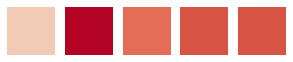

In [271]:
# Initialize an empty list to store RGBA values
neg95rgba_values = []

# Normalize the range between -5 and 5 degrees
normalized_values = (dsa['neg95'] - (-5)) / (5 - (-5))
print(normalized_values)

# Get the 'coolwarm' colormap
cmap = plt.get_cmap('coolwarm', 21)

# Iterate through the normalized values
for i in normalized_values:
    # Map the normalized value to a color using the colormap
    rgba = cmap(i)
    
    # Append the RGBA values to the list
    neg95rgba_values.append(rgba)
    
# Redefine the variable to drop the first two values
neg95rgba_values = neg95rgba_values[2:] 
print(neg95rgba_values)

# Create a 1xN grid of color boxes, where N is the length of medrgba_values
fig, axes = plt.subplots(1, len(neg95rgba_values), figsize=(len(neg95rgba_values), 2))

for i, rgba in enumerate(neg95rgba_values):
    ax = axes[i]

    # Create a rectangle filled with the specified color
    rectangle = plt.Rectangle((0, 0), 1, 1, fc=rgba)

    # Add the rectangle to the axis
    ax.add_patch(rectangle)

    # Set the aspect ratio to 'equal' so the rectangle appears as a square
    ax.set_aspect('equal')

    # Set axis limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Remove axis labels and ticks
    ax.axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Show the grid of color swatches
plt.show()

[(0.9473454036000001, 0.7946955047999998, 0.7169905057999999, 1.0), (0.705673158, 0.01555616, 0.150232812, 1.0), (0.8415338034000001, 0.3259621752, 0.2674943956, 1.0), (0.7783930206, 0.2076687008, 0.2059614254, 1.0), (0.7783930206, 0.2076687008, 0.2059614254, 1.0)]


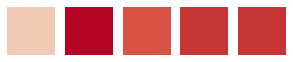

In [272]:
# Initialize an empty list to store RGBA values
medrgba_values = []

# Normalize the range between -5 and 5 degrees
normalized_values = (dsa['median'] - (-5)) / (5 - (-5))

# Get the 'coolwarm' colormap
cmap = plt.get_cmap('coolwarm', 21)

# Iterate through the normalized values
for i in normalized_values:
    # Map the normalized value to a color using the colormap
    rgba = cmap(i)
    
    # Append the RGBA values to the list
    medrgba_values.append(rgba)

# Redefine the variable to drop the first two values
medrgba_values = medrgba_values[2:]
print(medrgba_values)

# Create a 1xN grid of color boxes, where N is the length of medrgba_values
fig, axes = plt.subplots(1, len(medrgba_values), figsize=(len(medrgba_values), 2))

for i, rgba in enumerate(medrgba_values):
    ax = axes[i]

    # Create a rectangle filled with the specified color
    rectangle = plt.Rectangle((0, 0), 1, 1, fc=rgba)

    # Add the rectangle to the axis
    ax.add_patch(rectangle)

    # Set the aspect ratio to 'equal' so the rectangle appears as a square
    ax.set_aspect('equal')

    # Set axis limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Remove axis labels and ticks
    ax.axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Show the grid of color swatches
plt.show()

[(0.9473454036000001, 0.7946955047999998, 0.7169905057999999, 1.0), (0.705673158, 0.01555616, 0.150232812, 1.0), (0.705673158, 0.01555616, 0.150232812, 1.0), (0.705673158, 0.01555616, 0.150232812, 1.0), (0.705673158, 0.01555616, 0.150232812, 1.0)]


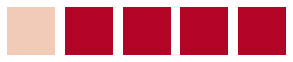

In [273]:
# Initialize an empty list to store RGBA values
pos95rgba_values = []

# Normalize the range between -5 and 5 degrees
normalized_values = (dsa['pos95'] - (-5)) / (5 - (-5))

# Get the 'coolwarm' colormap
cmap = plt.get_cmap('coolwarm', 21)

# Iterate through the normalized values
for i in normalized_values:
    # Map the normalized value to a color using the colormap
    rgba = cmap(i)
    
    # Append the RGBA values to the list
    pos95rgba_values.append(rgba)

# Redefine the variable to drop the first two values
pos95rgba_values = pos95rgba_values[2:]
print(pos95rgba_values)

# Create a 1xN grid of color boxes, where N is the length of medrgba_values
fig, axes = plt.subplots(1, len(pos95rgba_values), figsize=(len(pos95rgba_values), 2))

for i, rgba in enumerate(pos95rgba_values):
    ax = axes[i]

    # Create a rectangle filled with the specified color
    rectangle = plt.Rectangle((0, 0), 1, 1, fc=rgba)

    # Add the rectangle to the axis
    ax.add_patch(rectangle)

    # Set the aspect ratio to 'equal' so the rectangle appears as a square
    ax.set_aspect('equal')

    # Set axis limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Remove axis labels and ticks
    ax.axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Show the grid of color swatches
plt.show()

### Verifying the CMAP rgba colors

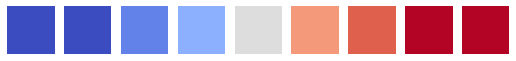

In [274]:
test = [-4.8, -3.8, -2.8, -1.8, 0, 1.8, 2.8, 3.8, 4.8]
rgba_values = []

# Get the 'coolwarm' colormap
cmap = plt.get_cmap('coolwarm', len(test))

for i in test:
    # Map the value 'i' to a color using the colormap
    rgba = cmap((i - min(test)) / (max(test) - min(test)))  # Normalize the value to [0, 1]
    rgba_values.append(rgba)

# Create a 1x9 grid of color boxes
fig, axes = plt.subplots(1, 9, figsize=(9, 2))

for i, rgba in enumerate(rgba_values):
    ax = axes[i]

    # Create a rectangle filled with the specified color
    rectangle = plt.Rectangle((0, 0), 1, 1, fc=rgba)

    # Add the rectangle to the axis
    ax.add_patch(rectangle)

    # Set the aspect ratio to 'equal' so the rectangle appears as a square
    ax.set_aspect('equal')

    # Set axis limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Remove axis labels and ticks
    ax.axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Show the grid of color swatches
plt.show()

## SCATTER PLOTTING FUNCTIONS

In [275]:
# Define the main plotting function that combines temperature contour and violin plot
def scatterplot(X, Y, diff, title, neg95, pos95, med, scatter_X, scatter_Y):
    
    # Create a figure with a single subplot for both temperature contour and violin plots
    fig, ax = plt.subplots(figsize=(15,5))

    # Define contour levels and colormap for the temperature contour plot
    contour_levels = [-5, -4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
    cmap = plt.get_cmap('coolwarm', 21)
    norm = plt.Normalize(vmin=-5, vmax=5)

    # Set the y-axis limits and invert it to display depth from top to bottom
    ax.set_ylim([0, -800])
    ax.invert_yaxis()

    # Set the x-axis limits for the temperature contour plot
    ax.set_xlim([120, 280])

    # Set the font size of tick labels on both x and y axes
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)

    # Set labels for the y-axis (depth) and x-axis (latitude)
    ax.set_ylabel("Depth (m)", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=16)

    # Plot the temperature data using contourf with specified contour levels and colormap
    cs = ax.contourf(X, Y, diff, levels=contour_levels, cmap=cmap, norm=norm)

    # Add a colorbar to the temperature contour plot
    cbar = plt.colorbar(cs, ax=ax, orientation='vertical', label='Celsius')

    # Scatter points with color coding for negative 95th percentile, median, and positive 95th percentile
    ax.scatter(
        scatter_X, 
        scatter_Y, 
        c=neg95, 
        marker='o', 
        s=150, 
        cmap=cmap, 
        vmin=-5, 
        vmax=5, 
        edgecolors='k'
    )

    ax.scatter(
        scatter_X, 
        scatter_Y, 
        c=med, 
        marker='o', 
        s=75, 
        cmap=cmap, 
        vmin=-5, 
        vmax=5
    )

    ax.scatter(
        scatter_X, 
        scatter_Y, 
        c=pos95, 
        marker='o', 
        s=15, 
        cmap=cmap, 
        vmin=-5, 
        vmax=5
    )

    # Set the title for the combined plot
    ax.set_title(title)
    
    # Set the font size of tick labels on both x and y axes for the combined plot
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)

    # Display the plot
    plt.tight_layout()
    plt.show()

## VIOLIN PLOTTING FUNCTIONS

In [276]:
def vplot(X, Y, diff, title, pos95, med, neg95, lon_sites, species_sites):

    # Create a figure with a single subplot for both temperature contour and violin plots
    fig, ax = plt.subplots(figsize=(15, 5))

    # Define contour levels and colormap for the temperature contour plot
    contour_levels = [-5, -4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
    cmap = plt.get_cmap('coolwarm', 21)
    norm = plt.Normalize(vmin=-5, vmax=5)

    # Set the y-axis limits and invert it to display depth from top to bottom
    ax.set_ylim([-800, 0])

    # Set the x-axis limits for the temperature contour plot
    ax.set_xlim([120, 280])

    # Set the font size of tick labels on both x and y axes
    for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(16)

    # Set labels for the y-axis (depth) and x-axis (longitude)
    ax.set_ylabel("Depth (m)", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=16)

    # Plot the temperature data using contourf with specified contour levels and colormap
    cs = ax.contourf(X, Y, diff, levels=contour_levels, cmap=cmap, norm=norm)

    # Add a colorbar to the temperature contour plot
    cbar = plt.colorbar(cs, ax=ax, orientation='vertical', label='Celsius')

    # Set the title for the combined plot
    ax.set_title(title)
    
    # Remove alkenones
    # exclude first two sites because they are alkenones for which there is no depth presence distribution in Lakhani_depths.xlsx
    species_sites_noAlks = species_sites[2:] 

    # Define custom positions for the violin plots on the x-axis
    # exclude first two sites because they are alkenones for which there is no depth presence distribution in Lakhani_depths.xlsx
    xpositions = np.array(lon_sites[2:])

    violin_data = [df_filtered[df_filtered['species'] == species_sites_noAlks[i]]['calc_depth'].values for i in range(len(xpositions))]   

    # Iterate over each site and create violins with specified colors
    for i in range(len(xpositions)):
        
        # Create the violin plot with a custom color
        parts = ax.violinplot(-violin_data[i], [np.array(xpositions[i])], vert=True, widths=9, showextrema=False)
        
        for pc in parts['bodies']:
            pc.set_facecolor(neg95rgba_values[i])  # Assign the custom color
            pc.set_edgecolor('black')  # Set the edge color to black
            pc.set_alpha(0.3)
        
        parts1 = ax.violinplot(-violin_data[i], [np.array(xpositions[i])], vert=True, widths=6, showextrema=False)
        
        for pc in parts1['bodies']:
            pc.set_facecolor(medrgba_values[i])  # Assign the custom color
            pc.set_alpha(0.4)
        
        parts2 = ax.violinplot(-violin_data[i], [np.array(xpositions[i])], vert=True, widths=2.5, showextrema=False)
        
        for pc in parts2['bodies']:
            pc.set_facecolor(pos95rgba_values[i])  # Assign the custom color
            pc.set_alpha(1)

    # Show the plot
    plt.show()

## COMBINED PLOT

In [277]:
def plot(X, Y, diff, title, pos95, med, neg95, lon_sites, species_sites, scatter_X, scatter_Y, scatter_med, scatter_pos95, scatter_neg95):

    # Create a figure with a single subplot for both temperature contour and violin plots
    fig, ax = plt.subplots(figsize=(15, 5))

    # Define contour levels and colormap for the temperature contour plot
    contour_levels = [-5, -4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
    cmap = plt.get_cmap('coolwarm', 21)
    norm = plt.Normalize(vmin=-5, vmax=5)

    # Set the y-axis limits and invert it to display depth from top to bottom
    ax.set_ylim([-800, 0])

    # Set the x-axis limits for the temperature contour plot
    ax.set_xlim([120, 280])

    # Set the font size of tick labels on both x and y axes
    for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(16)

    # Set labels for the y-axis (depth) and x-axis (longitude)
    ax.set_ylabel("Depth (m)", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=16)

    # Plot the temperature data using contourf with specified contour levels and colormap
    cs = ax.contourf(X, Y, diff, levels=contour_levels, cmap=cmap, norm=norm)

    # Add a colorbar to the temperature contour plot
    cbar = plt.colorbar(cs, ax=ax, orientation='vertical', label='Celsius')

    # Set the title for the combined plot
    ax.set_title(title)
    
    # Remove alkenones
    # exclude first two sites because they are alkenones for which there is no depth presence distribution in Lakhani_depths.xlsx
    species_sites_noAlks = species_sites[2:] 

    # Define custom positions for the violin plots on the x-axis
    # exclude first two sites because they are alkenones for which there is no depth presence distribution in Lakhani_depths.xlsx
    xpositions = np.array(lon_sites[2:])

    violin_data = [df_filtered[df_filtered['species'] == species_sites_noAlks[i]]['calc_depth'].values for i in range(len(xpositions))]   

    # Iterate over each site and create violins with specified colors
    for i in range(len(xpositions)):
        
        # Create the violin plot with a custom color
        parts = ax.violinplot(-violin_data[i], [np.array(xpositions[i])], vert=True, widths=9, showextrema=False)
        
        for pc in parts['bodies']:
            pc.set_facecolor(neg95rgba_values[i])  # Assign the custom color
            pc.set_edgecolor('black')  # Set the edge color to black
            pc.set_alpha(0.3)
        
        parts1 = ax.violinplot(-violin_data[i], [np.array(xpositions[i])], vert=True, widths=6, showextrema=False)
        
        for pc in parts1['bodies']:
            pc.set_facecolor(medrgba_values[i])  # Assign the custom color
            pc.set_alpha(0.4)
        
        parts2 = ax.violinplot(-violin_data[i], [np.array(xpositions[i])], vert=True, widths=2.5, showextrema=False)
        
        for pc in parts2['bodies']:
            pc.set_facecolor(pos95rgba_values[i])  # Assign the custom color
            pc.set_alpha(1)
            
    # Scatter points with color coding for negative 95th percentile, median, and positive 95th percentile
    ax.scatter(
        [scatter_X[0], scatter_X[1]],
        [scatter_Y[0], scatter_Y[1]],
        c=[neg95[0], neg95[1]],
        marker='o',
        s=150,
        cmap=cmap,
        vmin=-5,
        vmax=5,
        edgecolors='k'
    )

    ax.scatter(
        [scatter_X[0], scatter_X[1]],
        [scatter_Y[0], scatter_Y[1]],
        c=[med[0], med[1]],
        marker='o',
        s=75,
        cmap=cmap,
        vmin=-5,
        vmax=5
    )
    
    ax.scatter(
        [scatter_X[0], scatter_X[1]],
        [scatter_Y[0], scatter_Y[1]],
        c=[pos95[0], pos95[1]],
        marker='o',
        s=15,
        cmap=cmap,
        vmin=-5,
        vmax=5
    )

    # Show the plot
    plt.show()

## MULTI-MODEL MEAN

In [50]:
path = '/glade/u/home/nwrye/OceanTemps_Compiles/multimodel_mean.nc'

ds = xr.open_dataset(path)
ds

<xarray.Dataset>
Dimensions:  (lat: 5, lev: 40, lon: 360)
Coordinates:
  * lev      (lev) float32 5.0 15.0 25.0 35.0 ... 787.0025 878.8252 984.7058
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat      (lat) float64 -2.0 -1.0 0.0 1.0 2.0
Data variables:
    *empty*

## PLOTTING OF CURRENT PLOTS

## #1 CCSM4

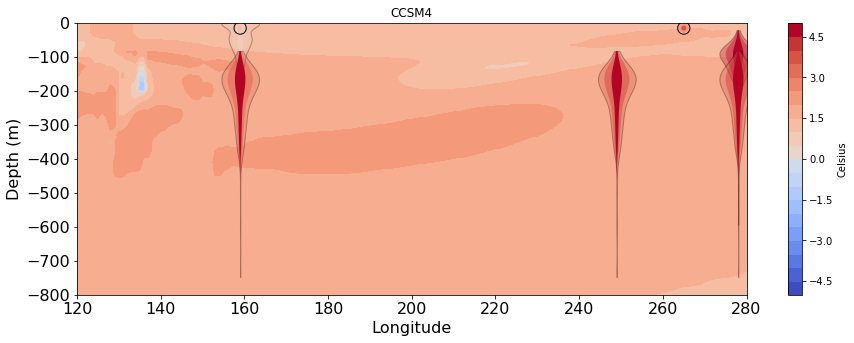

In [279]:
alk_sites = dsa.where(dsa['species'] == 'alkenones', drop=True)
plot(
    pliosds[0].lon,
    -pliosds[0]['lev'],
    horizontal_difference(pliosds[0], pisds[0]),
    title="CCSM4",
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95'],
    lon_sites=dsa['longitude'],
    species_sites=dsa['species'],
    scatter_X=alk_sites['longitude'],
    scatter_Y=alk_sites['depth'],
    scatter_med=alk_sites['median'], 
    scatter_pos95=alk_sites['pos95'],
    scatter_neg95=alk_sites['neg95']
)

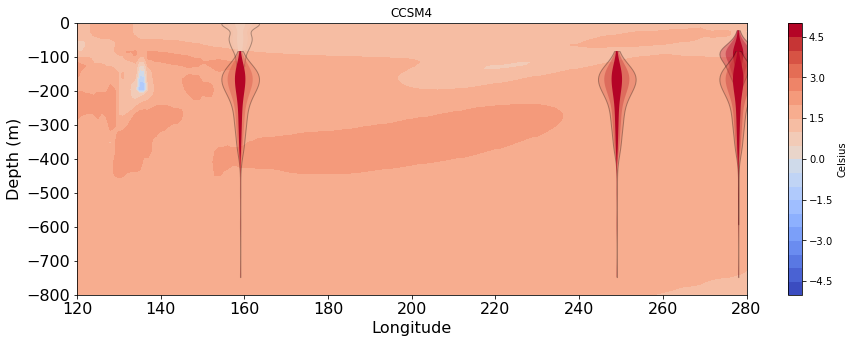

In [280]:
vplot(
    plio_datasets[0].lon,
    -plio_datasets[0]['lev'],
    horizontal_difference(plio_datasets[0], pi_datasets[0]),
    title="CCSM4",
    pos95 = dsa['pos95'],
    med = dsa['median'],
    neg95 = dsa['neg95'],
    lon_sites  = dsa['longitude'],
    species_sites = dsa['species']
)

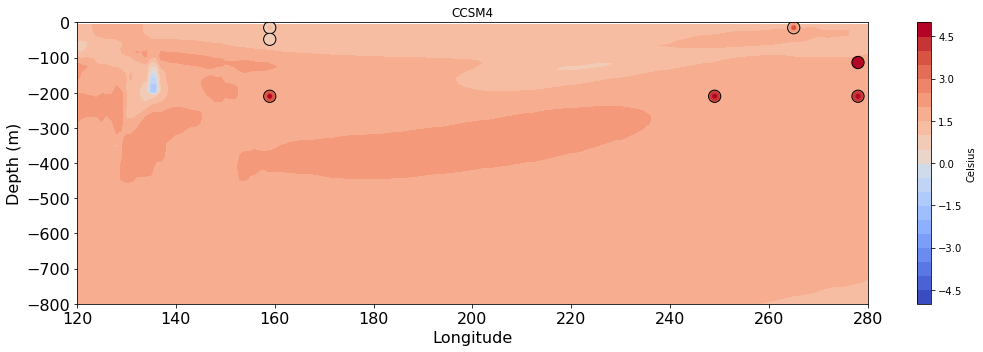

In [218]:
# Assuming `sds` is defined and contains the datasets
scatterplot(
    pliosds[0].lon,
    -pliosds[0]['lev'],
    horizontal_difference(pliosds[0], pisds[0]),
    title="CCSM4",
    scatter_X=dsa['longitude'],
    scatter_Y=dsa['depth'],
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95']
)

## #2 CESM 1.2

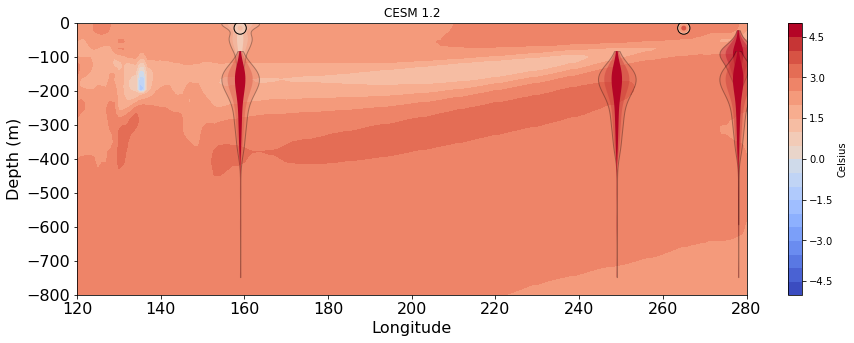

In [242]:
plot(
    pliosds[1].lon,
    -pliosds[1]['lev'],
    horizontal_difference(pliosds[1], pisds[1]),
    title="CESM 1.2",
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95'],
    lon_sites=dsa['longitude'],
    species_sites=dsa['species'],
    scatter_X=alk_sites['longitude'],
    scatter_Y=alk_sites['depth'],
    scatter_med=alk_sites['median'], 
    scatter_pos95=alk_sites['pos95'],
    scatter_neg95=alk_sites['neg95']
)

In [ ]:
vplot(
    plio_datasets[0].lon,
    -plio_datasets[0]['lev'],
    horizontal_difference(plio_datasets[0], pi_datasets[0]),
    title="CCSM4",
    pos95 = dsa['pos95'],
    med = dsa['median'],
    neg95 = dsa['neg95'],
    lon_sites  = dsa['longitude'],
    species_sites = dsa['species']
)

SyntaxError: invalid syntax (<ipython-input-241-ee2e730df6b9>, line 11)

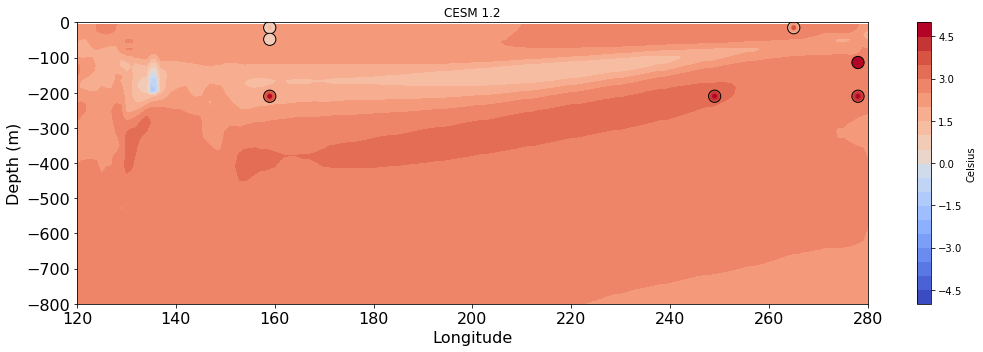

In [20]:
# Assuming `sds` is defined and contains the datasets
scatterplot(
    pliosds[1].lon,
    -pliosds[1]['lev'],
    horizontal_difference(pliosds[1], pisds[1]),
    title="CESM 1.2",
    scatter_X=dsa['longitude'],
    scatter_Y=dsa['depth'],
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95']
)

## #3 CESM 2

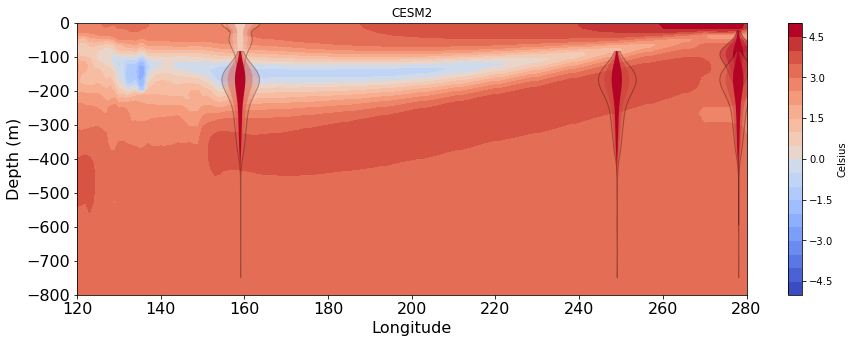

In [ ]:
vplot(
    pliosds[2].lon,
    -pliosds[2]['lev'],
    horizontal_difference(pliosds[2], pisds[2]),
    title = "CESM2",
    pos95 = dsa['pos95'],
    med = dsa['median'],
    neg95 = dsa['neg95'],
    lon_sites  = dsa['longitude'],
    species_sites = dsa['species']
)

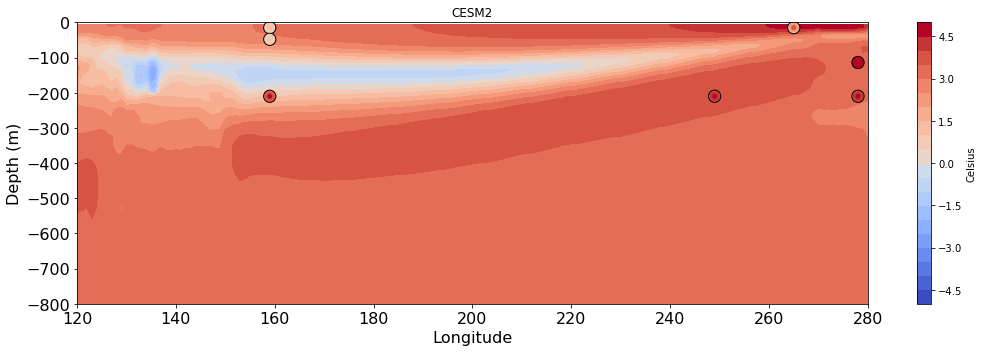

In [ ]:
# Assuming `sds` is defined and contains the datasets
scatterplot(
    pliosds[2].lon,
    -pliosds[2]['lev'],
    horizontal_difference(pliosds[2], pisds[2]),
    title="CESM2",
    scatter_X=dsa['longitude'],
    scatter_Y=dsa['depth'],
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95']
)

## #4 COSMOS

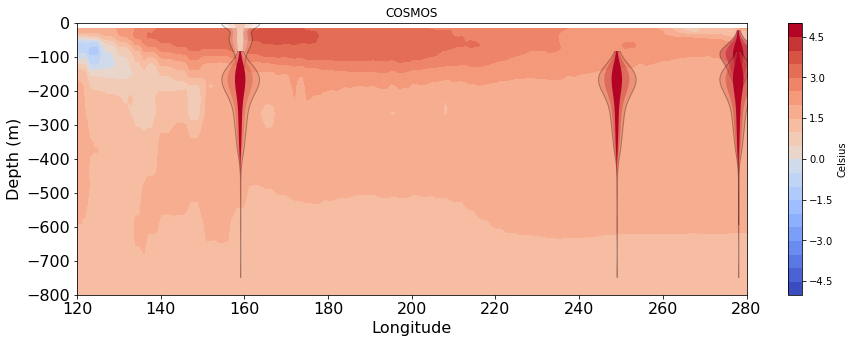

In [230]:
vplot(
    pliosds[3].lon,
    -pliosds[3]['lev'],
    horizontal_difference(pliosds[3], pisds[3]),
    title="COSMOS",
    pos95 = dsa['pos95'],
    med = dsa['median'],
    neg95 = dsa['neg95'],
    lon_sites  = dsa['longitude'],
    species_sites = dsa['species']
)

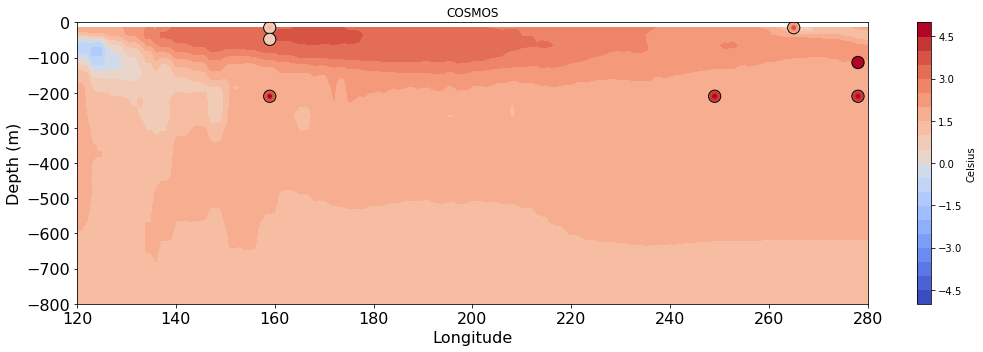

In [231]:
# Assuming `sds` is defined and contains the datasets
scatterplot(
    pliosds[3].lon,
    -pliosds[3]['lev'],
    horizontal_difference(pliosds[3], pisds[3]),
    title="COSMOS",
    scatter_X=dsa['longitude'],
    scatter_Y=dsa['depth'],
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95']
)

## #5 EC-Earth 3.3

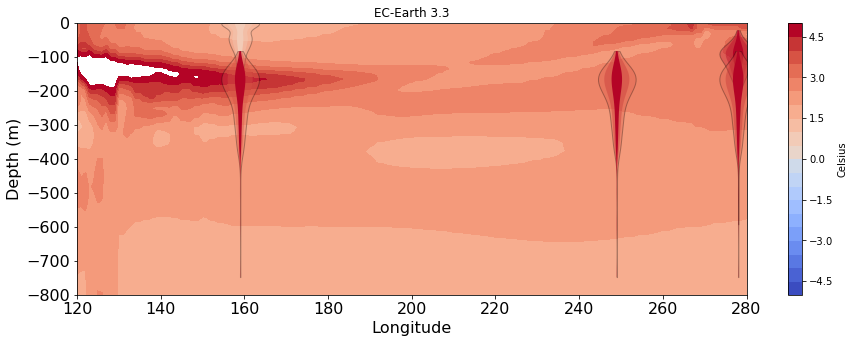

In [232]:
vplot(
    pliosds[4].lon,
    -pliosds[4]['lev'],
    horizontal_difference(pliosds[4], pisds[4]),
    title="EC-Earth 3.3",
    pos95 = dsa['pos95'],
    med = dsa['median'],
    neg95 = dsa['neg95'],
    lon_sites  = dsa['longitude'],
    species_sites = dsa['species']
)

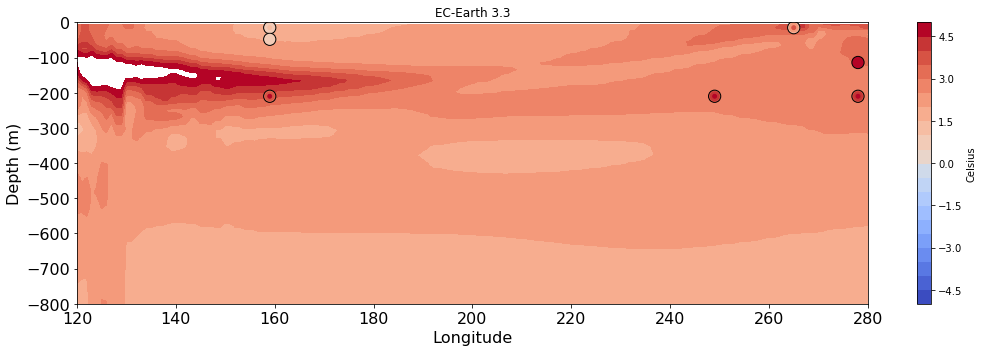

In [29]:
# Assuming `sds` is defined and contains the datasets
scatterplot(
    pliosds[4].lon,
    -pliosds[4]['lev'],
    horizontal_difference(pliosds[4], pisds[4]),
    title="EC-Earth 3.3",
    scatter_X=dsa['longitude'],
    scatter_Y=dsa['depth'],
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95']
)

## #6 HADGEM3 NEW 1997

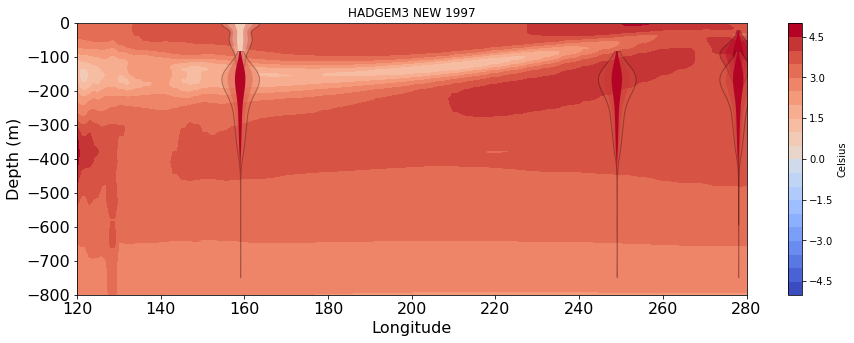

In [233]:
# Assuming `sds` is defined and contains the datasets
vplot(
    pliosds[5].lon,
    -pliosds[5]['lev'],
    horizontal_difference(pliosds[5], pisds[5]),
    title="HADGEM3 NEW 1997",
    pos95 = dsa['pos95'],
    med = dsa['median'],
    neg95 = dsa['neg95'],
    lon_sites  = dsa['longitude'],
    species_sites = dsa['species']
)

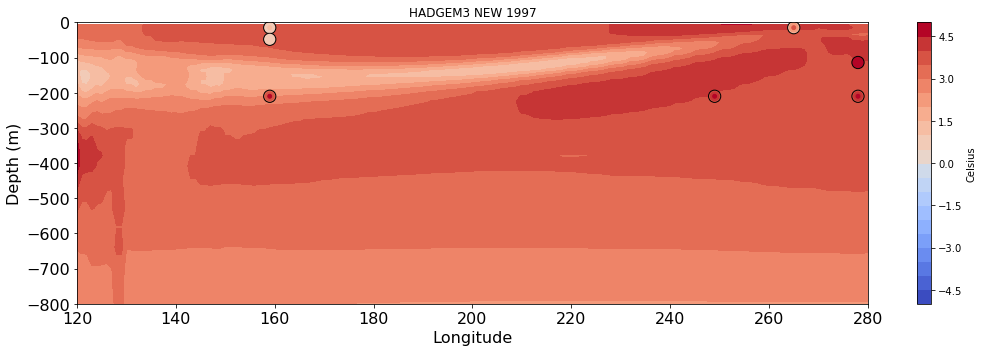

In [234]:
# Assuming `sds` is defined and contains the datasets
scatterplot(
    pliosds[5].lon,
    -pliosds[5]['lev'],
    horizontal_difference(pliosds[5], pisds[5]),
    title="HADGEM3 NEW 1997",
    scatter_X=dsa['longitude'],
    scatter_Y=dsa['depth'],
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95']
)

## #7 MIROC4_2004

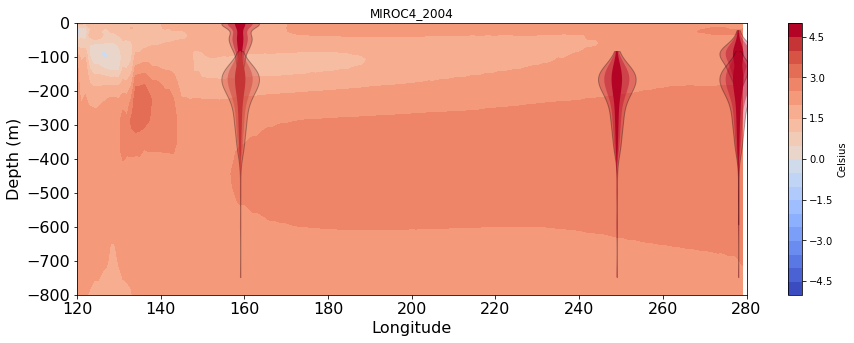

In [34]:
# Assuming `sds` is defined and contains the datasets
vplot(
    pliosds[6].lon,
    -pliosds[6]['lev'],
    horizontal_difference(pliosds[6], pisds[6]),
    title="MIROC4_2004",
    pos95 = dsa['pos95'],
    med = dsa['median'],
    neg95 = dsa['neg95'],
    lon_sites  = dsa['longitude'],
    species_sites = dsa['species']
)

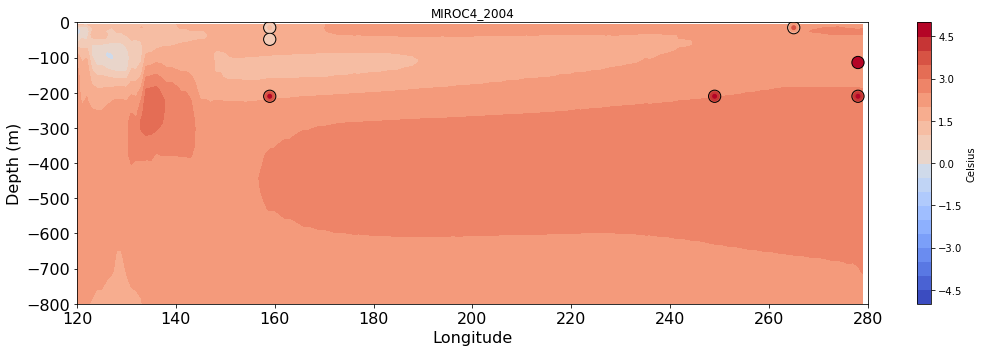

In [35]:
# Assuming `sds` is defined and contains the datasets
scatterplot(
    pliosds[6].lon,
    -pliosds[6]['lev'],
    horizontal_difference(pliosds[6], pisds[6]),
    title="MIROC4_2004",
    scatter_X=dsa['longitude'],
    scatter_Y=dsa['depth'],
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95']
)

## #8 Utrecht CESM1.0.5

TypeError: Input z must be at least a 2x2 array.

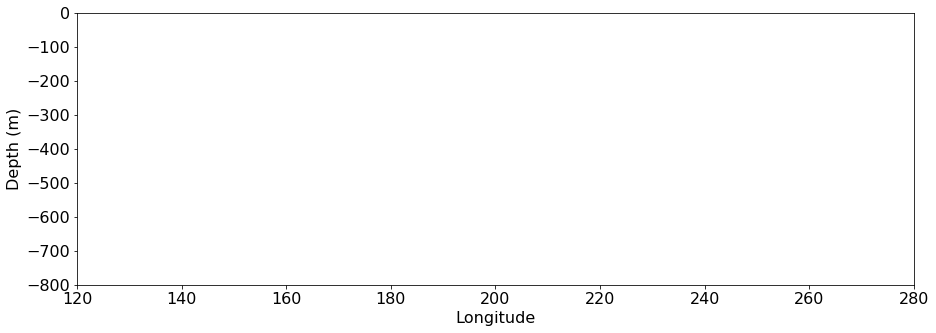

In [37]:
# Assuming `sds` is defined and contains the datasets
vplot(
    pliosds[7].lon,
    -pliosds[7]['lev'],
    horizontal_difference(pliosds[7], pisds[7]),
    title="Utrecht CESM1.0.5",
    pos95 = dsa['pos95'],
    med = dsa['median'],
    neg95 = dsa['neg95'],
    lon_sites  = dsa['longitude'],
    species_sites = dsa['species']
)

TypeError: Input z must be at least a 2x2 array.

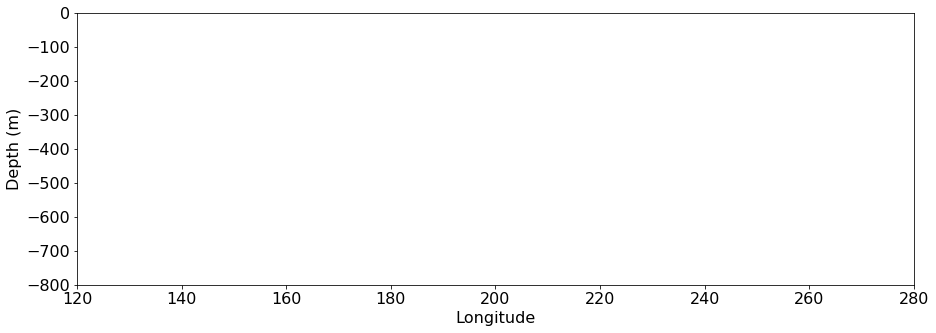

In [38]:
# Assuming `sds` is defined and contains the datasets
scatterplot(
    pliosds[7].lon,
    -pliosds[7]['lev'],
    horizontal_difference(pliosds[7], pisds[7]),
    title="Utrecht CESM1.0.5",
    scatter_X=dsa['longitude'],
    scatter_Y=dsa['depth'],
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95']
)

## #9 IPSLCM6A_LR

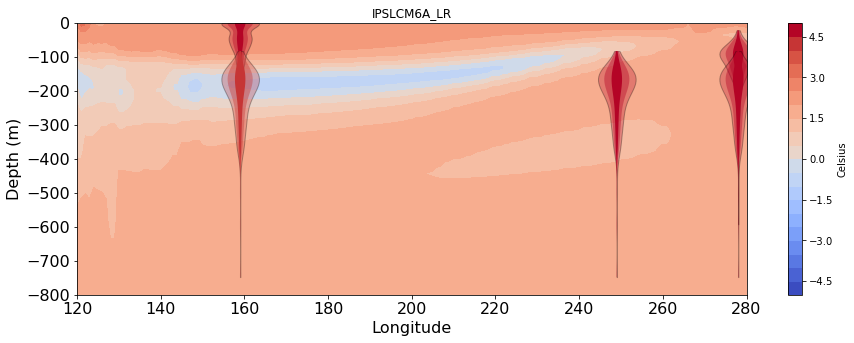

In [40]:
# Assuming `sds` is defined and contains the datasets
vplot(
    pliosds[8].lon,
    -pliosds[8]['lev'],
    horizontal_difference(pliosds[8], pisds[8]),
    title="IPSLCM6A_LR",
    pos95 = dsa['pos95'],
    med = dsa['median'],
    neg95 = dsa['neg95'],
    lon_sites  = dsa['longitude'],
    species_sites = dsa['species']
)

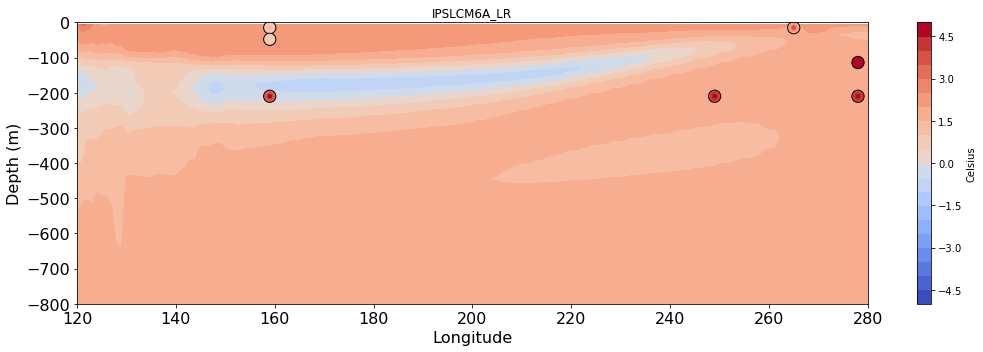

In [41]:
# Assuming `sds` is defined and contains the datasets
scatterplot(
    pliosds[8].lon,
    -pliosds[8]['lev'],
    horizontal_difference(pliosds[8], pisds[8]),
    title="IPSLCM6A_LR",
    scatter_X=dsa['longitude'],
    scatter_Y=dsa['depth'],
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95']
)

## #10 GISS

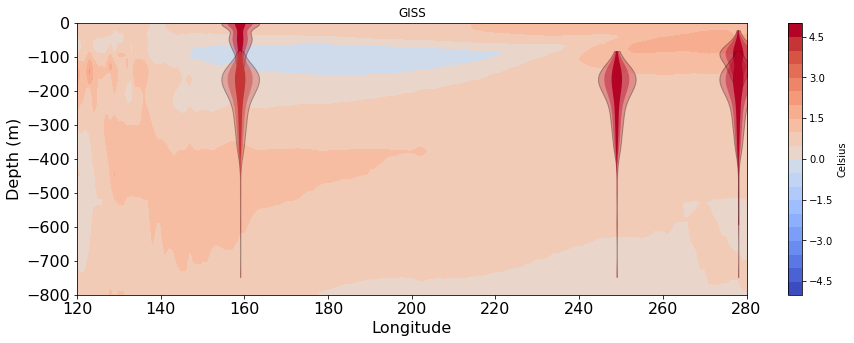

In [43]:
# Assuming `sds` is defined and contains the datasets
vplot(
    pliosds[9].lon,
    -pliosds[9]['lev'],
    horizontal_difference(pliosds[9], pisds[9]),
    title="GISS",
    pos95 = dsa['pos95'],
    med = dsa['median'],
    neg95 = dsa['neg95'],
    lon_sites  = dsa['longitude'],
    species_sites = dsa['species']
)

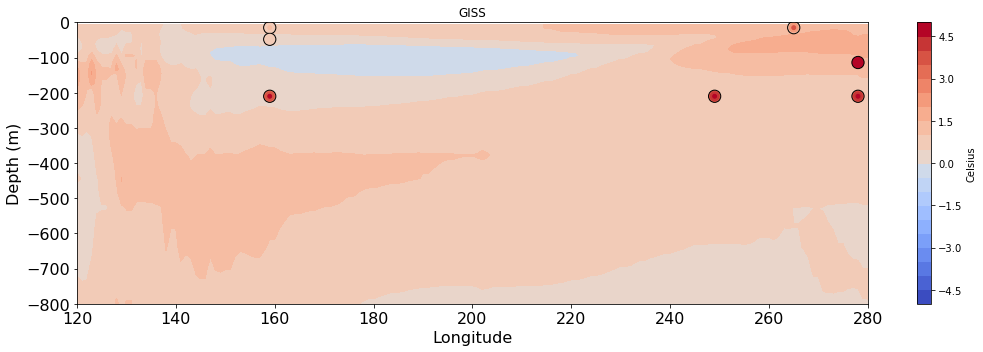

In [44]:
# Assuming `sds` is defined and contains the datasets
scatterplot(
    pliosds[9].lon,
    -pliosds[9]['lev'],
    horizontal_difference(pliosds[9], pisds[9]),
    title="GISS",
    scatter_X=dsa['longitude'],
    scatter_Y=dsa['depth'],
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95']
)

##  #11 LEEDS

In [47]:
pisds[10]

<xarray.Dataset>
Dimensions:  (lat: 5, lev: 40, lon: 360)
Coordinates:
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat      (lat) float64 -2.0 -1.0 0.0 1.0 2.0
  * lev      (lev) float32 5.0 15.0 25.0 35.0 ... 787.0025 878.8252 984.7058
    time     object ...
Data variables:
    TEMP     (lev, lat, lon) float64 28.99 28.96 29.26 29.26 ... 5.95 5.95 5.916

In [46]:
pliosds[10]

<xarray.Dataset>
Dimensions:  (lat: 5, lev: 40, lon: 360)
Coordinates:
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat      (lat) float64 -2.0 -1.0 0.0 1.0 2.0
  * lev      (lev) float32 5.0 15.0 25.0 35.0 ... 787.0025 878.8252 984.7058
    time     object ...
Data variables:
    TEMP     (lev, lat, lon) float64 28.99 28.96 29.26 29.26 ... 5.95 5.95 5.916

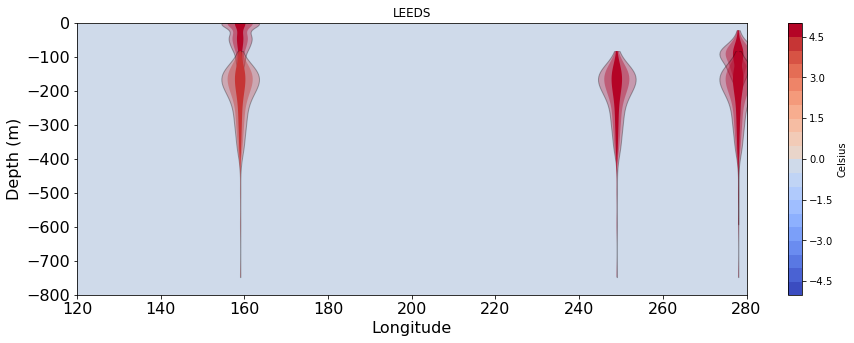

In [45]:
# Assuming `sds` is defined and contains the datasets
vplot(
    pliosds[10].lon,
    -pliosds[10]['lev'],
    horizontal_difference(pliosds[10], pisds[10]),
    title="LEEDS",
    pos95 = dsa['pos95'],
    med = dsa['median'],
    neg95 = dsa['neg95'],
    lon_sites  = dsa['longitude'],
    species_sites = dsa['species']
)

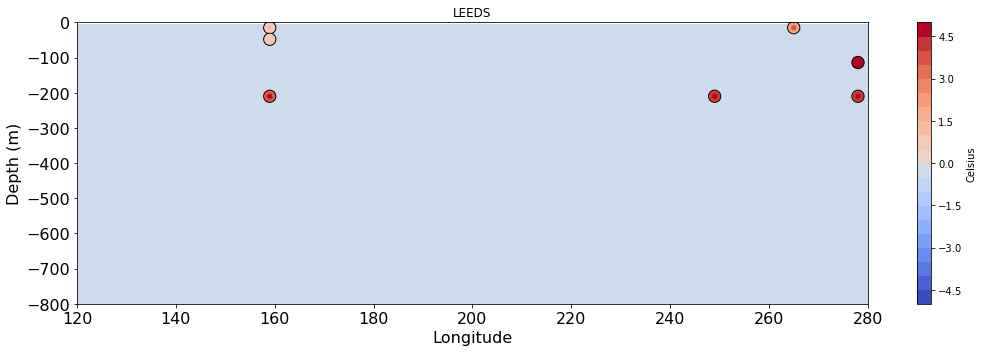

In [48]:
# Assuming `sds` is defined and contains the datasets
scatterplot(
    pliosds[10].lon,
    -pliosds[10]['lev'],
    horizontal_difference(pliosds[10], pisds[10]),
    title="LEEDS",
    scatter_X=dsa['longitude'],
    scatter_Y=dsa['depth'],
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95']
)

## #12 NorESM-F

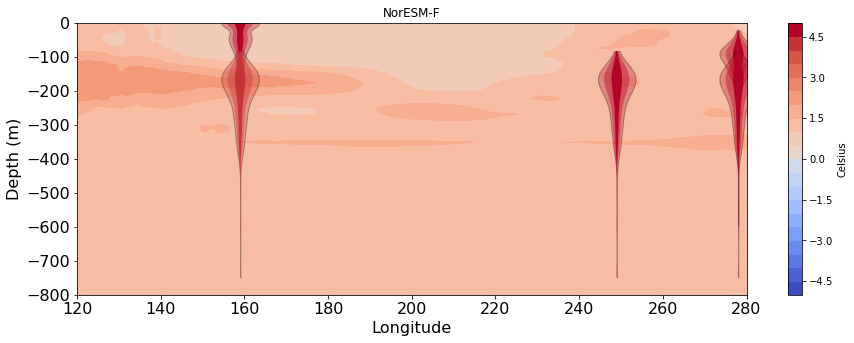

In [60]:
# Assuming `sds` is defined and contains the datasets
vplot(
    pliosds[11].lon,
    -pliosds[11]['lev'],
    horizontal_difference(pliosds[11], pisds[11]),
    title="NorESM-F",
    pos95 = dsa['pos95'],
    med = dsa['median'],
    neg95 = dsa['neg95'],
    lon_sites  = dsa['longitude'],
    species_sites = dsa['species']
)

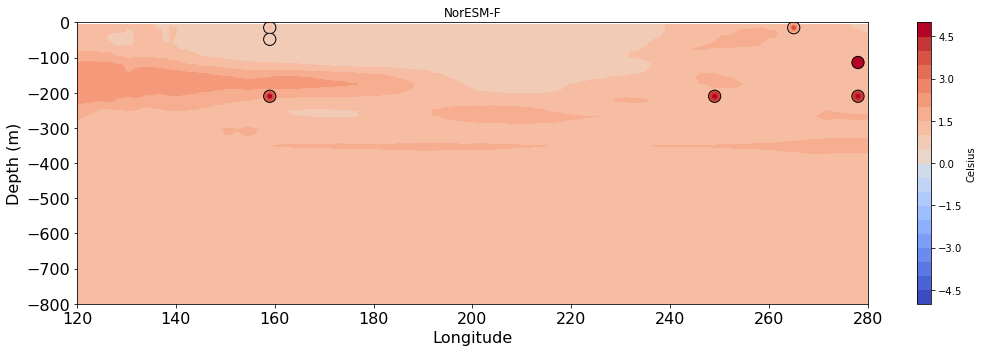

In [59]:
# Assuming `sds` is defined and contains the datasets
scatterplot(
    pliosds[11].lon,
    -pliosds[11]['lev'],
    horizontal_difference(pliosds[11], pisds[11]),
    title="NorESM-F",
    scatter_X=dsa['longitude'],
    scatter_Y=dsa['depth'],
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95']
)